Found one Kepler star with APOGEE age...

First cross-match APOGEE with Mcquillian

In [1]:
from HeaderP import *
import Astraea

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

Galah data

In [2]:
mcq_T1=pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',')
mcq_T2=pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_2_Non_Periodic.txt',delimiter=',')

In [3]:
frames = [mcq_T1, mcq_T2]
kepler=result = pd.concat(frames)
kepler=kepler.dropna(subset=['Prot'])
kepler=kepler.loc[kepler['w']>0.15].reset_index(drop=True)
print(np.shape(kepler))

(42799, 11)


In [4]:
gaia=pd.read_pickle('Data/gaia.pkl')
kepler=pd.merge(kepler,gaia,left_on='KID',right_on='kepid',how='inner')
kepler=kepler.drop_duplicates(keep='first')
print(np.shape(kepler))

(43809, 145)


APOGEE data

In [5]:
apogee=pd.read_pickle('Data/APOGEE.pkl')
print(np.shape(apogee))

(473306, 202)


cross-match APOGEE and GALAH

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


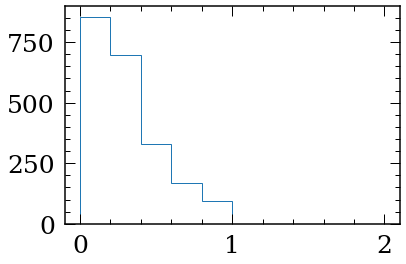

In [6]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
# galah
c1 = SkyCoord([i*u.deg for i in kepler['ra']], [i*u.deg for i in kepler['dec']], frame='icrs')
# apogee
c2 = SkyCoord([i*u.deg for i in apogee['RA']], [i*u.deg for i in apogee['DEC']], frame='icrs')
# cross-match
idx_sdss, d2d_sdss, d3d_sdss = c2.match_to_catalog_sky(c1)
idx=idx_sdss[d2d_sdss<1*u.arcsec]
d2d=d2d_sdss[d2d_sdss<1*u.arcsec]
plt.hist(d2d.arcsec, histtype='step', range=(0,2))

apogee_kepler=apogee[d2d_sdss<1*u.arcsec]
for i in kepler.columns:
    apogee_kepler[i]=kepler.iloc[idx][i].values
    

In [7]:
print(np.shape(apogee_kepler))

(2147, 347)


In [9]:
#apogee_kepler.to_pickle('Apogee_kepler_cm.pkl')

get ages

In [42]:
ages=pd.read_pickle('Data/CannonDR16_cut.pkl')


In [20]:
apogee_kepler=pd.merge(apogee_kepler,ages[['Age','Age_err','GAIA_SOURCE_ID']],
                      left_on='source_id',right_on='GAIA_SOURCE_ID')

In [22]:
apogee_kepler

,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,...,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist,Age,Age_err,GAIA_SOURCE_ID_y
0,apogee.apo25m.s.stars.K10_079+12.2M19404392+46...,apo25m.5010.K10_079+12.2M19404392+4640170,apogee.apo25m.s.r12-l33.K10_079+12.2M19404392+...,apStar-r12-2M19404392+4640170.fits,2M19404392+4640170,apo25m,5010,K10_079+12,12.561,0.026,...,0.0,0.0,12.561,11.902,11.845,none,0.494261,8.211617,4.48772,2080479207548793600


get Prot

In [32]:
apogee_kepler=pd.read_pickle('Apogee_kepler_cm.pkl')

In [33]:
features=['TEFF','TEFF_ERR','LOGG','LOGG_ERR','GAIA_PARALLAX','GAIA_PARALLAX_ERROR']

apogee_kepler=apogee_kepler[np.append(features,['Prot','Prot_err'])].dropna()
print(np.shape(apogee_kepler))

(2147, 8)


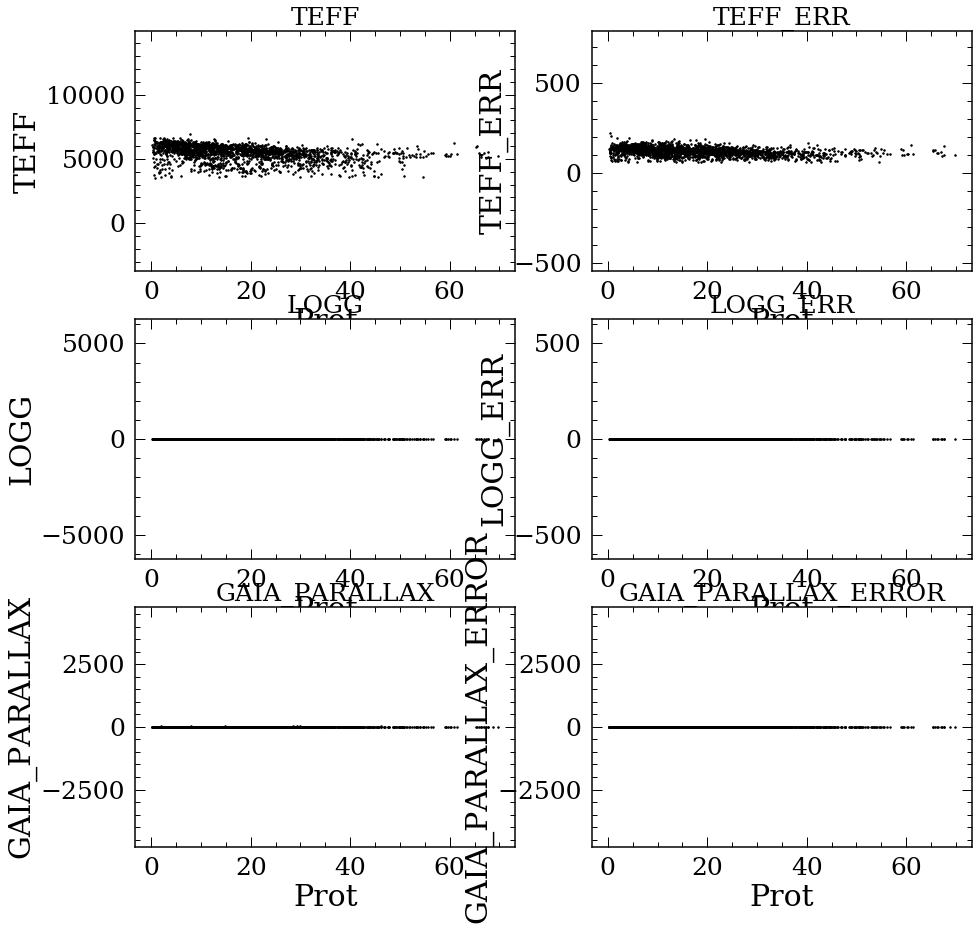

In [34]:
Astraea.plot_corr(apogee_kepler,features,MS=3)



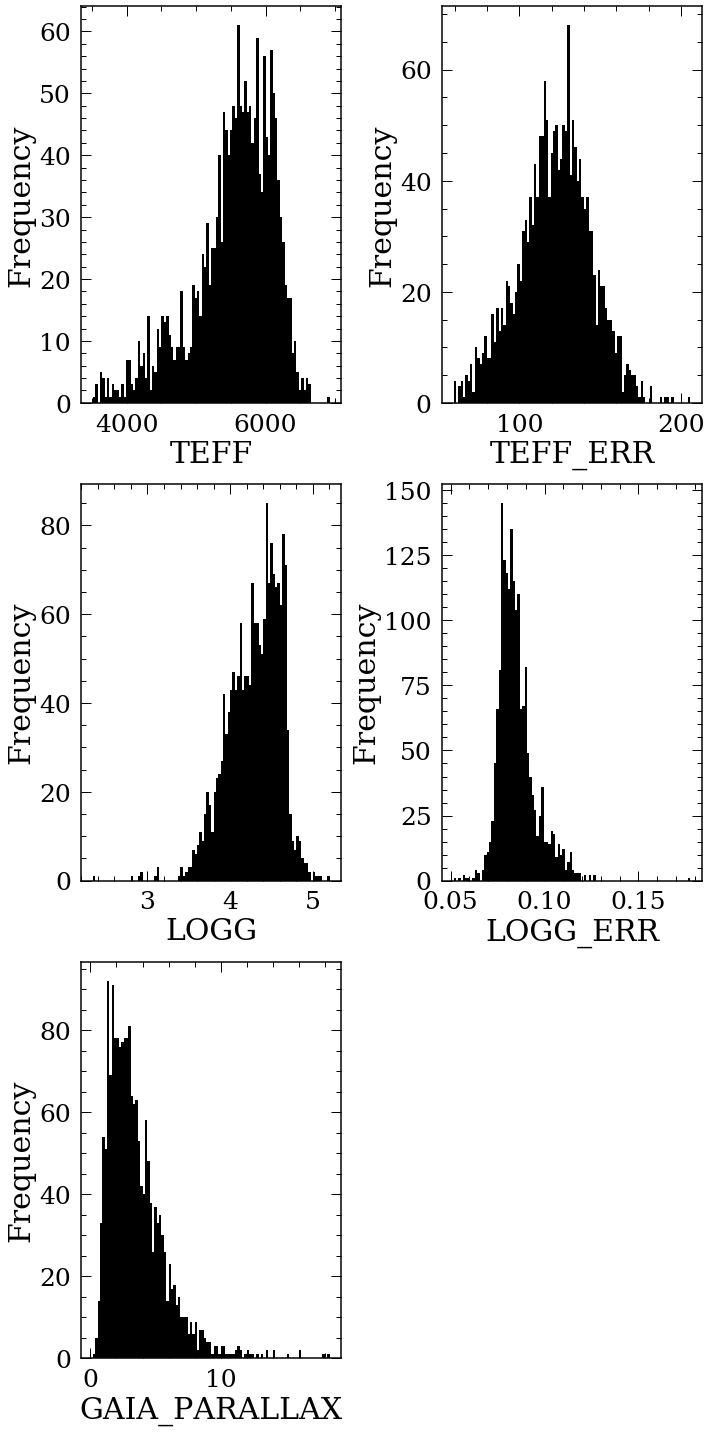

In [36]:
apogee_kepler=apogee_kepler.loc[apogee_kepler['TEFF']>0]
apogee_kepler=apogee_kepler.loc[apogee_kepler['TEFF_ERR']>0]
apogee_kepler=apogee_kepler.loc[apogee_kepler['LOGG']>-10]
apogee_kepler=apogee_kepler.loc[apogee_kepler['LOGG_ERR']>-10]
apogee_kepler=apogee_kepler.loc[apogee_kepler['GAIA_PARALLAX']>0]
apogee_kepler=apogee_kepler.loc[apogee_kepler['GAIA_PARALLAX_ERROR']<0.1]
apogee_kepler=apogee_kepler.loc[apogee_kepler['GAIA_PARALLAX_ERROR']>0].reset_index(drop=True)

titles=features
plt.figure(figsize=(10,20))
for i in range(1,len(features)):
    plt.subplot(3,2,i)
    plt.hist(apogee_kepler[features[i-1]],color='k',bins=100)
    plt.xlabel(features[i-1])
    plt.ylabel('Frequency')
plt.tight_layout()


In [37]:
regr, regr_outs = Astraea.RFregressor(apogee_kepler, features,
                                      target_var='Prot', target_var_err='Prot_err', n_estimators=100)


Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 6
Features attempt to train: ['TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'GAIA_PARALLAX', 'GAIA_PARALLAX_ERROR']
ID column not found, using index as ID!
1841 stars in dataframe!
1841 total stars used for RF!
1472 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.3238172218847827
Average chi^2 is: 4076.170022116821
Finished!


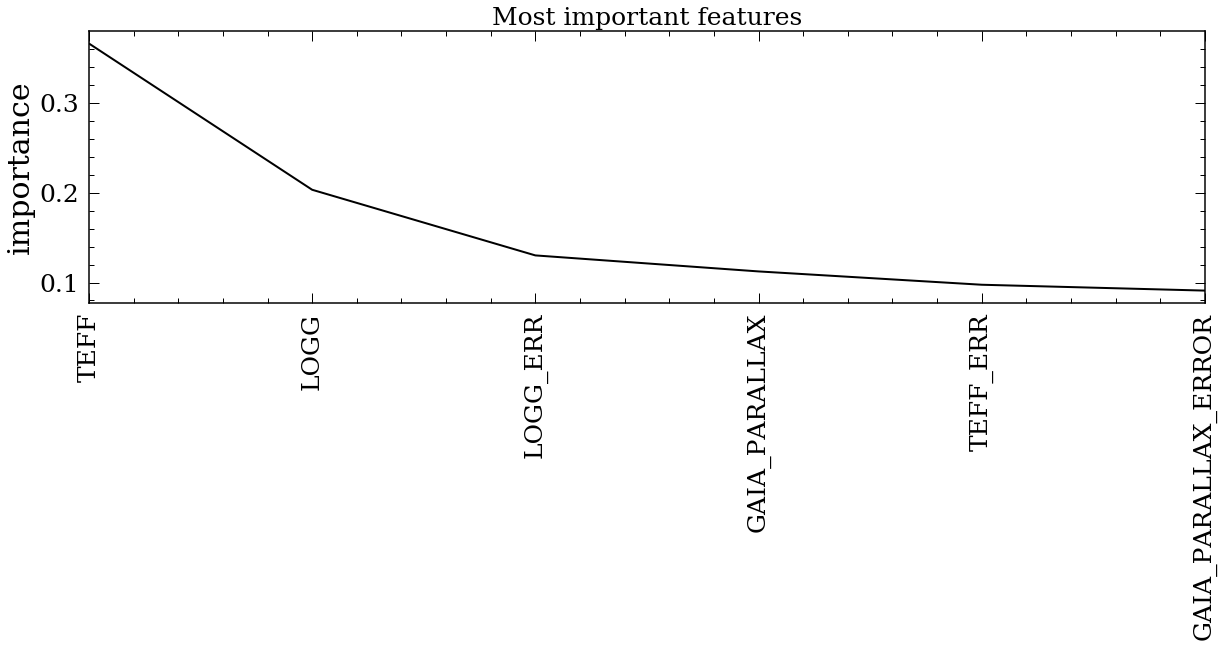

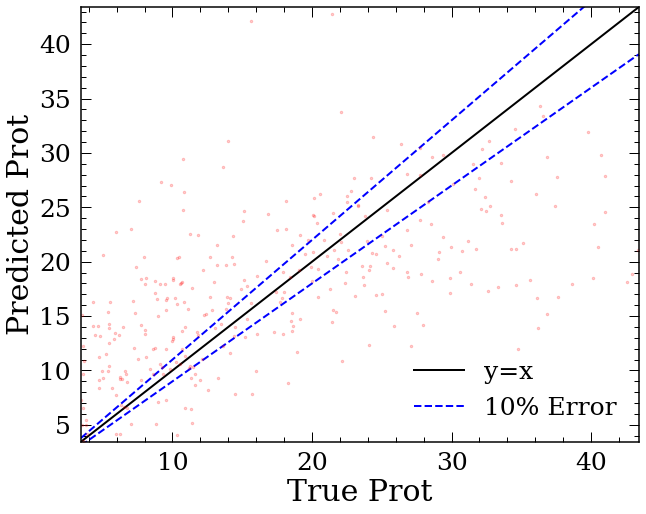

In [38]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Prot', MS=5)

In [43]:
apogee_feat=ages[regr_outs['actrualF']].dropna().reset_index(drop=True)
print(np.shape(apogee_feat))

(64399, 6)


(60947, 6)


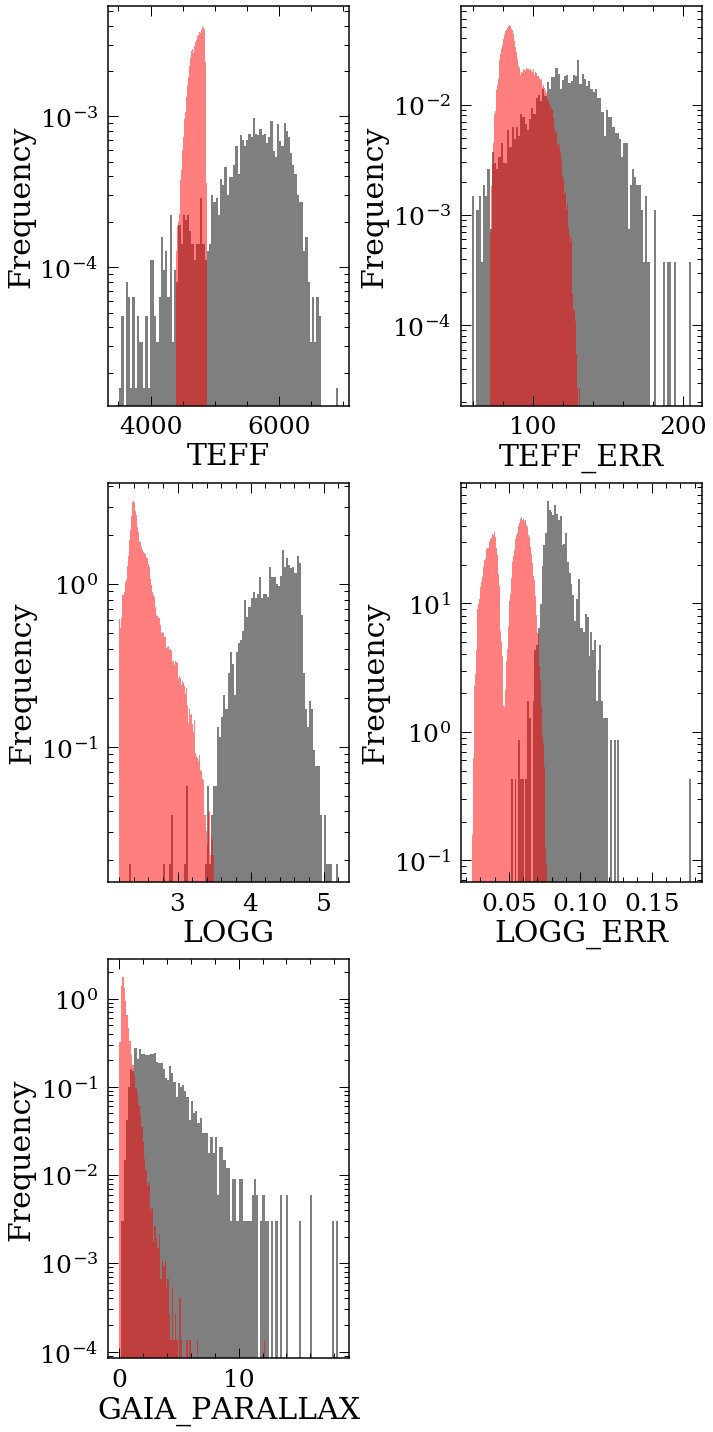

In [44]:
apogee_feat=apogee_feat.loc[apogee_feat['TEFF']>0]
apogee_feat=apogee_feat.loc[apogee_feat['TEFF_ERR']>0]
apogee_feat=apogee_feat.loc[apogee_feat['LOGG']>-10]
apogee_feat=apogee_feat.loc[apogee_feat['LOGG_ERR']>-10]
apogee_feat=apogee_feat.loc[apogee_feat['GAIA_PARALLAX']>0]
apogee_feat=apogee_feat.loc[apogee_feat['GAIA_PARALLAX_ERROR']<0.1]
apogee_feat=apogee_feat.loc[apogee_feat['GAIA_PARALLAX_ERROR']>0].reset_index(drop=True)
print(np.shape(apogee_feat))

titles=features
plt.figure(figsize=(10,20))
for i in range(1,len(features)):
    plt.subplot(3,2,i)
    plt.hist(apogee_kepler[features[i-1]],color='k',bins=100,alpha=0.5,density=True)
    plt.hist(apogee_feat[features[i-1]],color='r',bins=100,alpha=0.5,density=True)
    plt.yscale('log')
    plt.xlabel(features[i-1])
    plt.ylabel('Frequency')
plt.tight_layout()


